# **Long/Short Pairs Portfolio Algo**
### **Group：I Ching**

### **Import modules and databases**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%load_ext google.colab.data_table 
%matplotlib inline

# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2022-02-03 05:39:41--  https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py [following]
--2022-02-03 05:39:42--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2949 (2.9K) [text/plain]
Saving to: ‘pairslib.py.1’

pairslib.py.1       100%[===================>]   2.88K  --.-KB/s    in 0s      

2022-02-03 05:39:42 (31.8 MB/s) - ‘pairslib.py.1’ saved [2949/2949]



### **Define related functions**

In [ ]:
# Functions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import pandas_datareader.data as web


# Set the image size
CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 12, 8


def zscore(series):
    return (series - series.mean()) / np.std(series)


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['p-value'], ')')
      plotPair(researchData, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Look for cointegrated pairs
def find_cointegrated_pairs(df, p_value):
    n = df.shape[1]
    keys = df.keys()
    pairs1 = []
    pairs2 = []
    pairs3 = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = df[keys[i]]
            stock2 = df[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)
            pvalue = result[1]
            if pvalue < p_value:
                pairs1.append(keys[i])
                pairs2.append(keys[j])
                pairs3.append(pvalue)
    cointinfo = pd.DataFrame({'stockA':pairs1, 'stockB':pairs2, 'p-value':pairs3})
    
    # looks up the sectors for the stocksA and stockB
    pairsDf = cointinfo.merge(stocksInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))
    pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
    pairsDf.drop(['shortName_A', 'shortName_B'], axis=1, inplace=True)
    return pairsDf

### back test related functions

# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, stockA, stockB, window1, window2):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Set the tradingParams
  dollarValue = 10000

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['ma1'] = backTest_df['pxRatio'].rolling(window=window1,center=False).mean()
  backTest_df['ma2'] = backTest_df['pxRatio'].rolling(window=window2,center=False).mean()
  backTest_df['std'] = backTest_df['pxRatio'].rolling(window=window2,center=False).std()
  backTest_df['zscore'] = (backTest_df['ma1'] - backTest_df['ma2'])/backTest_df['std']
  backTest_df['dollarValue'] = dollarValue

  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  backTest_df.dropna(inplace = True)
  
  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    zscore = row['zscore']
    # mark signal = 1 if zscore > 1 (Diverge outside the upper band)
    if zscore > 1:
      signal = 1

    # mark signal = -1 if zscore < -1 (Diverge outside the lower band)
    elif zscore < -1:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and zscore > 0.75 (Trade entered but not converge back yet)
      if signal == 1 and zscore > 0.75:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and < -0.75 (Trade entered but not converge back yet)
      elif signal == -1 and zscore < -0.75:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, window1, window2, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    pairsPortfolioBackTest.append(backTest(testData, stockA, stockB, window1 ,window2)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest

### **Select liquid equities**

In [ ]:
# Select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

# The details of the 173 stocks listed by stocksFilteredInfo are in the researchData

,code,shortName,industry,sector,turnover
1,0700.HK,TENCENT,Information Technology,Online and Mobile Games,1.094491e+10
0,9988.HK,BABA-SW,Information Technology,E-commerce and Internet,6.289126e+09
27,0981.HK,SMIC,Information Technology,Semi-conductor,5.881712e+09
3,3690.HK,MEITUAN-W,Information Technology,E-commerce and Internet,4.727324e+09
8,0388.HK,HKEX,Financial,Other financial services,2.732908e+09
...,...,...,...,...,...
140,0136.HK,HENGTEN NET,Energy,Photovoltaic Solar,1.084515e+08
91,0880.HK,SJM HOLDINGS,Betting,Macau Gaming,1.077015e+08
158,3606.HK,FUYAO GLASS,Automobile production and distribution,Cars parts and maintenance,1.056159e+08
152,3933.HK,UNITED LAB,Medicine,Pharmaceutical,1.038379e+08


### **researchData Pre-processing**

In [ ]:
# Delete and impute null values
researchData.drop(['YEAHKA', 'CC NEW LIFE'], axis=1, inplace=True)
researchData = researchData.fillna(value=None, method='pad')

### **Look for stock pairs through cointegration relations**

In [ ]:
# Look for stock pairs through cointegration relations
pairsDf = find_cointegrated_pairs(researchData, 0.01)

pairsDf

,stockA,stockB,p-value,sector_A,sector_B,sameSector
0,TENCENT,ZHONGSHENG HLDG,0.000247,Online and Mobile Games,Auto sales,False
1,TENCENT,CHINA TOWER,0.008976,Online and Mobile Games,Telecommunications Equipment,False
2,TENCENT,CHINA SHENHUA,0.008628,Online and Mobile Games,Coal industry related,False
3,MEITUAN-W,MEIDONG AUTO,0.004090,E-commerce and Internet,Auto sales,False
4,AIA,LENOVO GROUP,0.002522,International Insurance,Computer and Peripheral Products,False
...,...,...,...,...,...,...
198,ZTE,HEC PHARM,0.003823,Telecommunications Equipment,Pharmaceutical,False
199,SD GOLD,COFCO MEAT,0.001747,Precious metals,Agricultural and Fishery products,False
200,COFCO MEAT,COMEC,0.008583,Agricultural and Fishery products,Shipbuilding related,False
201,ZHAOJIN MINING,COMEC,0.003543,Precious metals,Shipbuilding related,False



 5 : HSBC HOLDINGS vs HANG SENG BANK ( 0.006885893595819625 )


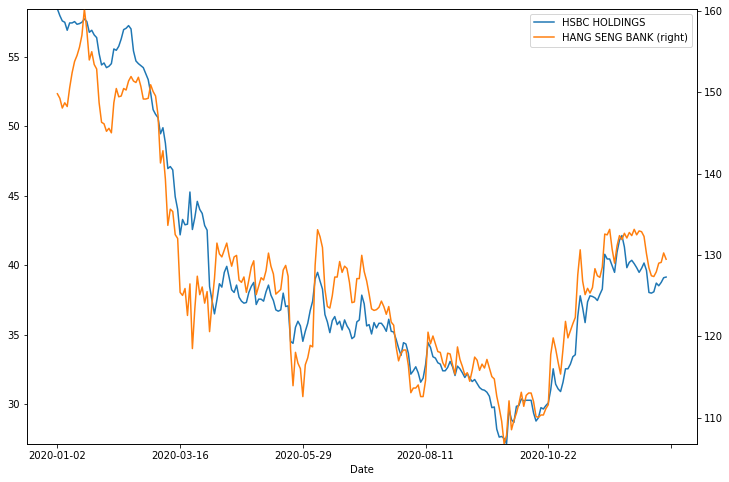


 124 : PA GOODDOCTOR vs CANSINOBIO-B ( 0.0014464417205305225 )


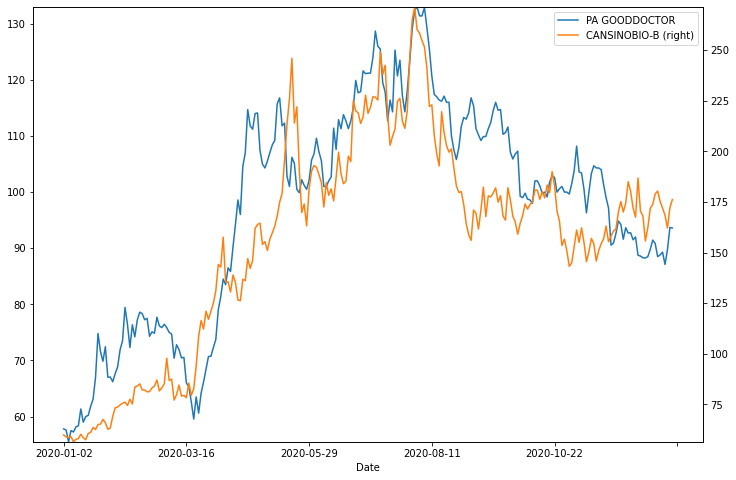

In [ ]:
# Plot all the correlated Pairs with same sector
plotManyPair(pairsDf[(pairsDf.sameSector == True)])

### **Ideas for building a trading strategy**

In [ ]:
selected_pair = 124

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']

In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

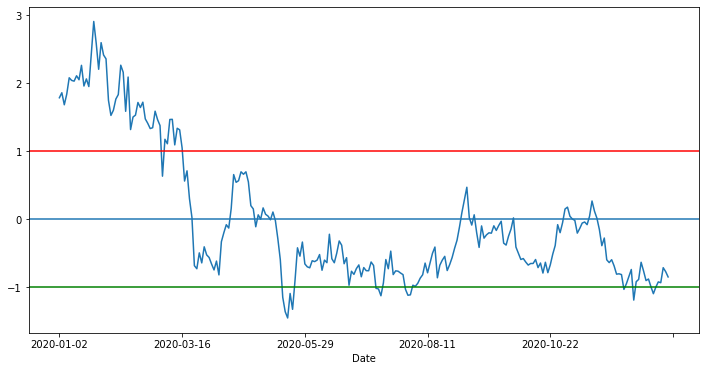

In [ ]:
zscore(pairResearchData[AB_stock]).plot(figsize=(12,6))
plt.axhline(zscore(pairResearchData[AB_stock]).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

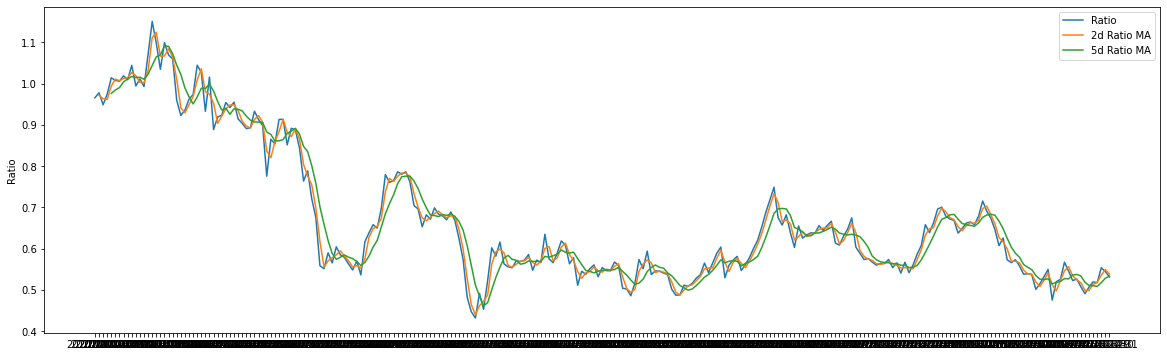

In [ ]:
ratios_mavg2 = pairResearchData[AB_stock].rolling(window=2, center=False).mean()
ratios_mavg5 = pairResearchData[AB_stock].rolling(window=5, center=False).mean()
std_5 = pairResearchData[AB_stock].rolling(window=5, center=False).std()
zscore_5_2 = (ratios_mavg2 - ratios_mavg5)/std_5
plt.figure(figsize=(20, 6))
plt.plot(pairResearchData[AB_stock].index, pairResearchData[AB_stock].values)
plt.plot(ratios_mavg2.index, ratios_mavg2.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.legend(['Ratio', '2d Ratio MA', '5d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

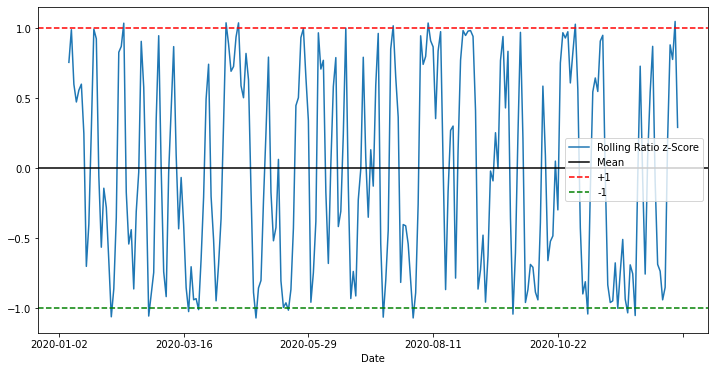

In [ ]:
plt.figure(figsize=(12,6))
zscore_5_2.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

### **Using researchData to test the algo**

Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)
Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)
*** PnL: 14275.719476771787


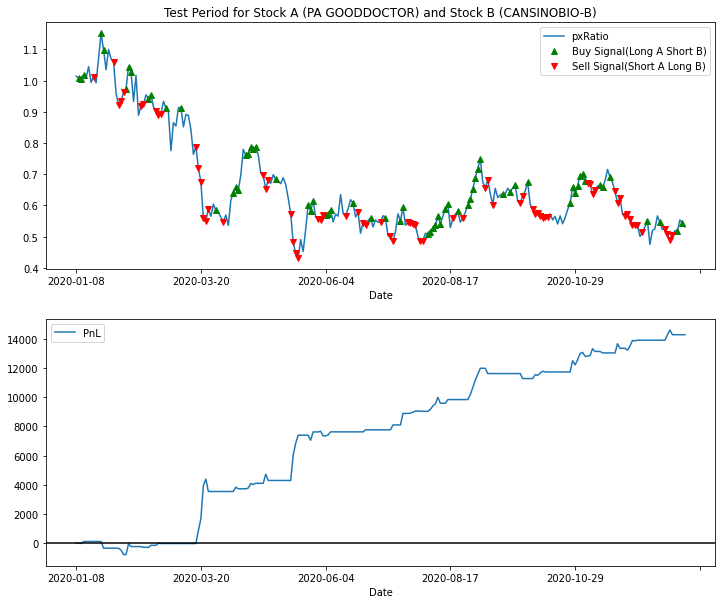

In [ ]:
backTest_df = backTest(researchData, PAIR_STOCK_A, PAIR_STOCK_B, 5, 2)

# Calcuate the PnL in test period
print("Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)")
print("Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print("*** PnL:", pnl)
print("==================================")

# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, legend=True)
pnl_df.nSignal.plot(ax=axes[0], color='g', label='Buy Signal(Long A Short B)',linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], color='r', label='Sell Signal(Short A Long B)',linestyle='None', marker='v', legend=True)
axes[0].legend(loc ='upper right')
pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10))
axes[1].axhline(y=0, color='black', linestyle='-')

### **Backtesting**

In [ ]:
# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]
print("Total pairs with same sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, 5, 2, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with same sectors for backtesting: 2
----------------------------------------------------------
HSBC HOLDINGS vs HANG SENG BANK ---> $ 1158.7716431918889
PA GOODDOCTOR vs CANSINOBIO-B ---> $ 10863.076937790776
PortfolioPnl: $ 12021.848580982665


,stockA,stocksB,Pnl
0,HSBC HOLDINGS,HANG SENG BANK,1158.771643
1,PA GOODDOCTOR,CANSINOBIO-B,10863.076938
